# KNN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

os.chdir('/content/drive/MyDrive/IronInsight')
os.getcwd()

'/content/drive/MyDrive/IronInsight'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('cleaned_data_v3.csv')

In [ ]:
df.head()

,Name,Sex,Age,BodyweightKg,WeightClassKg,BestBench,Date
0,Maysar Olaymi,M,24.0,43.5,49.0,91.0,2017-02-21
1,Mohammad Alshnaiti,M,15.0,39.5,49.0,70.0,2017-02-21
2,Ali Al-Darraji,M,35.0,52.3,54.0,142.0,2017-02-21
3,Ziad Androun,M,31.0,63.5,65.0,131.0,2017-02-21
4,Hasan Al-Tameemi,M,39.0,64.4,65.0,157.0,2017-02-21


## Data in form for KNN
* Each entry single person
* List for BestBench, Age, Bodyweight
* Get sex into numeric (OHE)
* Probably want to normalize BestBench, Age, Bodyweight

In [ ]:
df = df.sort_values(by=['Name', 'Date'])
df

,Name,Sex,Age,BodyweightKg,WeightClassKg,BestBench,Date
419000,A Kashirin,M,27.5,72.50,74.0,130.00,2016-04-02
418518,A Kashirin,M,27.5,73.50,74.0,145.00,2016-10-03
231660,A'Dren Hye,M,21.5,92.00,93.0,165.00,2015-03-21
577628,A'Dren Hye,M,21.5,99.16,100.0,185.97,2015-12-12
204299,A'Dren Hye,M,22.5,91.10,93.0,155.00,2016-06-04
...,...,...,...,...,...,...,...
150311,龍神 雅幸,M,48.5,85.75,93.0,160.00,2019-11-30
148205,﨑村 厚,M,68.5,73.15,74.0,100.00,2015-05-31
146634,﨑村 厚,M,69.5,73.60,74.0,95.00,2016-05-29
148828,﨑村 厚,M,70.5,73.10,74.0,100.00,2017-05-28


In [ ]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
print(df['Age'].dtype)
print(df['BodyweightKg'].dtype)
print(df['WeightClassKg'].dtype)
print(df['BestBench'].dtype)
print(df['Date'].dtype)

float64
float64
float64
float64
datetime64[ns]


In [ ]:
grouped_df = df.groupby('Name').agg({
    'BestBench': list,      # Collect all bench maxes into a list
    'Age': list,          # Use the first recorded age (or average it if preferred)
    'Sex': 'first',          # Use the first recorded sex (assuming it doesn't change)
    'BodyweightKg': list,       # Collect bodyweights into a list (corresponding to each bench max)
    'Date': list
}).reset_index()

grouped_df.head()

,Name,BestBench,Age,Sex,BodyweightKg,Date
0,A Kashirin,"[130.0, 145.0]","[27.5, 27.5]",M,"[72.5, 73.5]","[2016-04-02 00:00:00, 2016-10-03 00:00:00]"
1,A'Dren Hye,"[165.0, 185.97, 155.0, 195.0, 195.0]","[21.5, 21.5, 22.5, 23.5, 23.5]",M,"[92.0, 99.16, 91.1, 104.1, 104.1]","[2015-03-21 00:00:00, 2015-12-12 00:00:00, 201..."
2,A'ron Washington,"[170.0, 182.5]","[22.5, 23.0]",M,"[116.4, 123.4]","[2023-09-09 00:00:00, 2024-03-09 00:00:00]"
3,A. Abdullaeva,"[65.0, 75.0]","[22.5, 23.5]",F,"[62.4, 71.05]","[2016-10-03 00:00:00, 2017-10-02 00:00:00]"
4,A. Alshabaev,"[100.0, 105.0, 112.5, 125.0]","[18.5, 19.5, 19.5, 21.5]",M,"[71.5, 71.7, 72.8, 83.1]","[2015-10-05 00:00:00, 2016-04-02 00:00:00, 201..."


In [ ]:
grouped_df['StartBench'] = grouped_df['BestBench'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)
grouped_df['StartAge'] = grouped_df['Age'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)
grouped_df['StartWeight'] = grouped_df['BodyweightKg'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)
grouped_df['StartDate'] = pd.to_datetime(grouped_df['Date'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None))
grouped_df.head()

,Name,BestBench,Age,Sex,BodyweightKg,Date,StartBench,StartAge,StartWeight,StartDate
0,A Kashirin,"[130.0, 145.0]","[27.5, 27.5]",M,"[72.5, 73.5]","[2016-04-02 00:00:00, 2016-10-03 00:00:00]",130.0,27.5,72.5,2016-04-02
1,A'Dren Hye,"[165.0, 185.97, 155.0, 195.0, 195.0]","[21.5, 21.5, 22.5, 23.5, 23.5]",M,"[92.0, 99.16, 91.1, 104.1, 104.1]","[2015-03-21 00:00:00, 2015-12-12 00:00:00, 201...",165.0,21.5,92.0,2015-03-21
2,A'ron Washington,"[170.0, 182.5]","[22.5, 23.0]",M,"[116.4, 123.4]","[2023-09-09 00:00:00, 2024-03-09 00:00:00]",170.0,22.5,116.4,2023-09-09
3,A. Abdullaeva,"[65.0, 75.0]","[22.5, 23.5]",F,"[62.4, 71.05]","[2016-10-03 00:00:00, 2017-10-02 00:00:00]",65.0,22.5,62.4,2016-10-03
4,A. Alshabaev,"[100.0, 105.0, 112.5, 125.0]","[18.5, 19.5, 19.5, 21.5]",M,"[71.5, 71.7, 72.8, 83.1]","[2015-10-05 00:00:00, 2016-04-02 00:00:00, 201...",100.0,18.5,71.5,2015-10-05


In [ ]:
print(grouped_df['StartDate'].dtype)
print(grouped_df['Date'].dtype)

datetime64[ns]
object


In [ ]:
def calculate_days_after(start_date, dates):
  return [(date - start_date).days for date in dates]

grouped_df['DaysAfterStart'] = grouped_df.apply(lambda row: calculate_days_after(row['StartDate'], row['Date']), axis=1)

grouped_df = grouped_df[grouped_df['DaysAfterStart'].apply(len) > 1]

grouped_df.head()

,Name,BestBench,Age,Sex,BodyweightKg,Date,StartBench,StartAge,StartWeight,StartDate,DaysAfterStart
0,A Kashirin,"[130.0, 145.0]","[27.5, 27.5]",M,"[72.5, 73.5]","[2016-04-02 00:00:00, 2016-10-03 00:00:00]",130.0,27.5,72.5,2016-04-02,"[0, 184]"
1,A'Dren Hye,"[165.0, 185.97, 155.0, 195.0, 195.0]","[21.5, 21.5, 22.5, 23.5, 23.5]",M,"[92.0, 99.16, 91.1, 104.1, 104.1]","[2015-03-21 00:00:00, 2015-12-12 00:00:00, 201...",165.0,21.5,92.0,2015-03-21,"[0, 266, 441, 749, 749]"
2,A'ron Washington,"[170.0, 182.5]","[22.5, 23.0]",M,"[116.4, 123.4]","[2023-09-09 00:00:00, 2024-03-09 00:00:00]",170.0,22.5,116.4,2023-09-09,"[0, 182]"
3,A. Abdullaeva,"[65.0, 75.0]","[22.5, 23.5]",F,"[62.4, 71.05]","[2016-10-03 00:00:00, 2017-10-02 00:00:00]",65.0,22.5,62.4,2016-10-03,"[0, 364]"
4,A. Alshabaev,"[100.0, 105.0, 112.5, 125.0]","[18.5, 19.5, 19.5, 21.5]",M,"[71.5, 71.7, 72.8, 83.1]","[2015-10-05 00:00:00, 2016-04-02 00:00:00, 201...",100.0,18.5,71.5,2015-10-05,"[0, 180, 364, 878]"


In [ ]:
grouped_df = grouped_df.drop('Date', axis=1)
grouped_df = grouped_df.drop('StartDate', axis=1)
grouped_df = grouped_df.drop('BodyweightKg', axis=1)
grouped_df = grouped_df.drop('Age', axis=1)
grouped_df = grouped_df.drop('Name', axis=1)
grouped_df

,BestBench,Sex,StartBench,StartAge,StartWeight,DaysAfterStart
0,"[130.0, 145.0]",M,130.0,27.5,72.50,"[0, 184]"
1,"[165.0, 185.97, 155.0, 195.0, 195.0]",M,165.0,21.5,92.00,"[0, 266, 441, 749, 749]"
2,"[170.0, 182.5]",M,170.0,22.5,116.40,"[0, 182]"
3,"[65.0, 75.0]",F,65.0,22.5,62.40,"[0, 364]"
4,"[100.0, 105.0, 112.5, 125.0]",M,100.0,18.5,71.50,"[0, 180, 364, 878]"
...,...,...,...,...,...,...
161540,"[162.5, 182.5, 182.5]",M,162.5,20.5,122.95,"[0, 714, 714]"
161541,"[95.0, 95.0]",M,95.0,19.5,61.55,"[0, 183]"
161542,"[140.0, 135.0]",M,140.0,19.5,83.00,"[0, 364]"
161543,"[120.0, 152.5, 160.0]",M,120.0,44.0,86.90,"[0, 1294, 1609]"


In [ ]:
data = grouped_df.to_numpy()

## KNN class

* Match K closest neighbors in StartBench, StartAge, StartWeight and Sex
  * Each must be scaled/OHE
* Calculate linear progression estimate for each training data point on Bench and Days
* Based on linear progression estimate of determined K closest neighbors, what can we predict our progression will be in givenX days

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.base import clone
import sklearn.neighbors
from sklearn.metrics import mean_squared_error
from math import sqrt

class KNNReg:

    def __init__(self, k=10, model=LinearRegression()):
        """ Initialize our custom KNN Regression
        Args:
            k: the number of nearest neighbors to consider for classification
        """
        self.k = k
        self.scalerBench = StandardScaler()
        self.scalerBW = StandardScaler()
        self.scalerAge = StandardScaler()
        self.sexEncoder = OneHotEncoder(sparse_output=False)
        self.model = model
        self.linearEstimates = []
        # going to try using ball tree to find closest points to start
        self.ball_tree = None

    # Define helper function to fit a regression model and make predictions
    # Will be used in fit to fit each datapoint with a model for future predictions
    def get_bench_progression(self, days, bench):
        days = np.array(days).reshape(-1, 1)
        bench = np.array(bench)
        model_used = clone(self.model)
        model_used.fit(days, bench)
        return model_used

    def fit(self, X):
        """ Fit the model using the provided data
        Args:
            X: The training data. 2D array of with the following features in
               columns ((List of Bench's), Sex, Age, Weight, StartBench, (List of Days from Start each Corresponding to a Bench))
        Returns: Fit instance of KNNReg (self)
        """
        # fit each linear regression
        for i in range(len(X)):
          self.linearEstimates.append(self.get_bench_progression(X[i,5], X[i,0]))

        # fit scalers for scaling data (ensure columns are reshaped for 2D input)
        X_bench_scaled = self.scalerBench.fit_transform(np.array(X[:, 4]).reshape(-1, 1))
        X_weight_scaled = self.scalerBW.fit_transform(np.array(X[:, 3]).reshape(-1, 1))
        X_age_scaled = self.scalerAge.fit_transform(np.array(X[:, 2]).reshape(-1, 1))
        # fit encoder and transform Sex
        X_sex_encoded = self.sexEncoder.fit_transform(np.array(X[:, 1]).reshape(-1, 1))

        # combine all features into a single array
        new_X = np.hstack((X_bench_scaled, X_weight_scaled, X_age_scaled, X_sex_encoded))

        # fit BallTree
        self.ball_tree = sklearn.neighbors.BallTree(new_X)

        return self

    def get_progression(self, indices_nearest_k,  days_to_estimate, distances_nearest_k=None):
        """ Given indices of the nearest k neighbors for each point,
            report the majority label of those points.
        Args:
            k_nearest_indices: 2-d array of the indices of training neighbors, of shape (M, k)
            days_to_estimate:
            k_nearest_distances: 2-d array of the corresponding distances of training neighbors, of shape (M, k)
        Returns:
        """
        days_to_estimate = np.array(days_to_estimate).reshape(-1, 1)
        ave_estimates = np.empty(indices_nearest_k.shape[0])

        for r in range(indices_nearest_k.shape[0]):
          row_estimates = []
          row_indices_nearest_k = list(indices_nearest_k[r])

          for i in row_indices_nearest_k:
            estimate = (self.linearEstimates[i]).predict(days_to_estimate[r].reshape(-1, 1))
            row_estimates.append(estimate)

          ave_estimates[r] = np.mean(row_estimates)

        return ave_estimates



    def predict(self, X_test, days_to_estimate):
        """ Given new data points, classify them according to the training data
            provided in self.fit and estimate
        Args:
            X_test: feature vectors (num_samples, num_features)
            days_to_estimate: array of Ints corresonding to X_test of size (num_samples,)
        Returns:
            1-D array of predicted averages (num_samples,)
        """
        distances_nearest_k, indices_nearest_k = np.array([]), np.array([])

        # initialize tree
        tree = self.ball_tree

        X_test_bench_scaled = self.scalerBench.transform(np.array(X_test[:, 4]).reshape(-1, 1))
        X_test_weight_scaled = self.scalerBW.transform(np.array(X_test[:, 3]).reshape(-1, 1))
        X_test_age_scaled = self.scalerAge.transform(np.array(X_test[:, 2]).reshape(-1, 1))
        X_test_sex_encoded = self.sexEncoder.transform(np.array(X_test[:, 1]).reshape(-1, 1))

        X_test_scaled_encoded = np.hstack((X_test_bench_scaled, X_test_weight_scaled, X_test_age_scaled, X_test_sex_encoded))

        # use tree to predict based on input data
        distances_nearest_k, indices_nearest_k = tree.query(X_test_scaled_encoded, k=self.k)

        return self.get_progression(indices_nearest_k, days_to_estimate, distances_nearest_k)

    def error(self, X_test):
        """ Return the () of the classifier on the data (X, y)
        Args:
            X_test: matrix of shape (num_samples, num_features)
        Returns:
        """
        days_to_estimate = [item[1] if len(item) > 1 else None for item in X_test[:, 5]]
        real_bench_values = np.array([item[1] if len(item) > 1 else None for item in X_test[:, 0]])
        estimates = np.array(self.predict(X_test, days_to_estimate))

        # Root Mean Squared Error (RMSE)
        rmse = np.sqrt(mean_squared_error(real_bench_values, estimates))

        # Mean Absolute Percentage Error (MAPE)
        mape = np.mean(np.abs((real_bench_values - estimates) / real_bench_values)) * 100

        # Average Error
        ave_error = np.mean(np.abs(estimates - real_bench_values))

        return rmse, mape, ave_error




## Model Notes/Evaluation

* Pros
  * Does well on small days number that are well represented by data (less than 365)
* Cons
  * Takes Bodyweight into account for start but doesn't consider change in BW
  * Big Days number (greater than 365) can get weird as not many datapoints have represent above this

In [ ]:
# subset of each data for finding best regression models to use in KNNReg model
# use subsets simply for faster training, when reporting use full test and train datasets
train_subset = train[np.random.choice(train.shape[0], size=int(0.2 * train.shape[0]), replace=False)]
test_subset = test[np.random.choice(test.shape[0], size=int(0.2 * test.shape[0]), replace=False)]

In [ ]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

models = [Lasso(), Ridge(), ElasticNet(), LinearRegression()]
rmse_values = []
mape_values = []
avg_error_values = []
k = 5
for m in models:
  model = KNNReg(k=k, model=m)
  model.fit(train_subset)
  rmse, mape, abs = model.error(test_subset)
  rmse_values.append(rmse)
  mape_values.append(mape)
  avg_error_values.append(abs)

In [ ]:
for idx, model in enumerate(models):
    print(f"Model: {model.__class__.__name__}")
    print(f"  RMSE: {rmse_values[idx]}")
    print(f"  MAPE: {mape_values[idx]}")
    print(f"  Abs Error: {avg_error_values[idx]}")
    print("-" * 30)

Model: Lasso
  RMSE: 21.379385534056365
  MAPE: 9.040713265152297
  Abs Error: 8.77551826687083
------------------------------
Model: Ridge
  RMSE: 19.64618638494074
  MAPE: 8.976392468359041
  Abs Error: 8.756667306027387
------------------------------
Model: ElasticNet
  RMSE: 19.137668279387203
  MAPE: 8.917942726569652
  Abs Error: 8.70558577107702
------------------------------
Model: LinearRegression
  RMSE: 25.951542985674852
  MAPE: 9.261966439889596
  Abs Error: 8.940895189798809
------------------------------


In [ ]:
rmse_values = []
mape_values = []
avg_error_values = []
ks = [5,10,20,30]
for k in ks:
  model = KNNReg(k=k, model=ElasticNet())
  model.fit(train_subset)
  rmse, mape, abs = model.error(test_subset)
  rmse_values.append(rmse)
  mape_values.append(mape)
  avg_error_values.append(abs)

In [ ]:
for idx, k in enumerate(ks):
    print(f"k = {k}")
    print(f"  RMSE: {rmse_values[idx]}")
    print(f"  MAPE: {mape_values[idx]}")
    print(f"  Abs Error: {avg_error_values[idx]}")
    print("-" * 30)

k = 5
  RMSE: 19.137668279387203
  MAPE: 8.917942726569652
  Abs Error: 8.70558577107702
------------------------------
k = 10
  RMSE: 16.53102119365649
  MAPE: 8.38086088843093
  Abs Error: 8.142994932334906
------------------------------
k = 20
  RMSE: 16.07640039226584
  MAPE: 8.190860676381078
  Abs Error: 7.906125148560194
------------------------------
k = 30
  RMSE: 15.548642141678082
  MAPE: 8.16978469776547
  Abs Error: 7.832276952916038
------------------------------


In [ ]:
results = []

for alpha in [10000]:
  for l1 in [.01]:

    model = KNNReg(k=30, model=ElasticNet(alpha=alpha, l1_ratio=l1))
    model.fit(train)

    rmse, mape, avg_error = model.error(test)

    results.append({
        "alpha": alpha,
        "l1_ratio": l1,
        "rmse": rmse,
        "mape": mape,
        "avg_error": avg_error,
    })

    # Print results
    print(f"RMSE: {rmse:.4f}, MAPE: {mape:.2f}%, Avg Error: {avg_error:.4f}")

RMSE: 11.6756, MAPE: 6.81%, Avg Error: 6.6611


In [ ]:
from sklearn.linear_model import ElasticNet
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

k_values = [5, 10, 20]
rmse_values = []
mape_values = []
avg_error_values = []
actual_values = np.array([item[1] if len(item) > 1 else None for item in test[:, 0]])
predicted_values = []

for k in k_values:
  model = KNNReg(k=k, model=ElasticNet(alpha=10000, l1_ratio=.01))
  model.fit(train)

  y_hat =  np.array(model.predict(test, [item[1] if len(item) > 1 else None for item in test[:, 5]]))
  rmse, mape, abs = model.error(test)

  rmse_values.append(rmse)
  mape_values.append(mape)
  avg_error_values.append(abs)
  predicted_values.append(y_hat)

residuals = actual_values - predicted_values

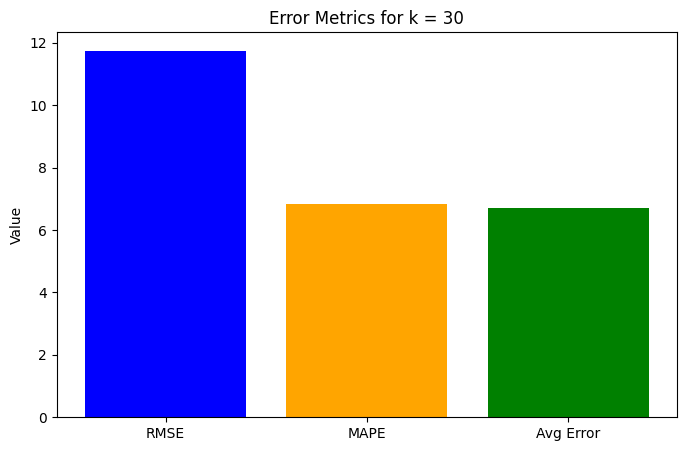

In [ ]:
# Bar Chart of RMSE, MAPE, and Average Error
plt.figure(figsize=(8, 5))
error_metrics = ['RMSE', 'MAPE', 'Avg Error']
values = [rmse_values[-1], mape_values[-1], avg_error_values[-1]]
plt.bar(error_metrics, values, color=['blue', 'orange', 'green'])
plt.title('Error Metrics for k = 20')
plt.ylabel('Value')
plt.show()

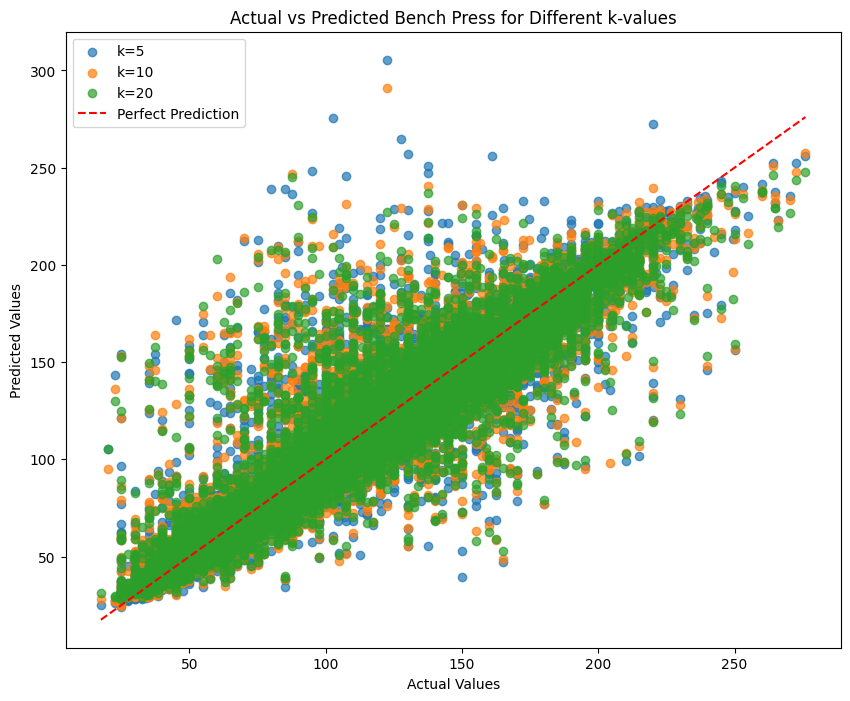

In [ ]:
# Scatter Plot of Actual vs Predicted Values
plt.figure(figsize=(10, 8))

for i, k in enumerate(k_values):
    plt.scatter(actual_values, predicted_values[i], label=f'k={k}', alpha=0.7)

# Add the perfect prediction reference line
plt.plot([actual_values.min(), actual_values.max()],
         [actual_values.min(), actual_values.max()],
         color='red', linestyle='--', label='Perfect Prediction')

plt.title('Actual vs Predicted Bench Press for Different k-values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

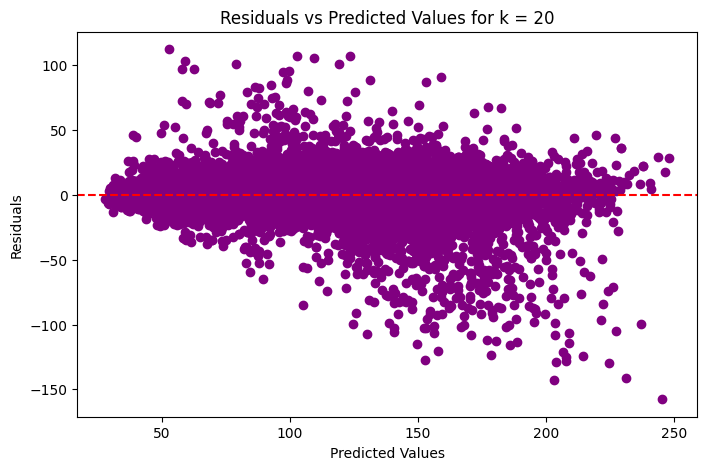

In [ ]:
# Residual Plot
plt.figure(figsize=(8, 5))
plt.scatter(predicted_values[-1], residuals[-1], color='purple')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values for k = 20')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

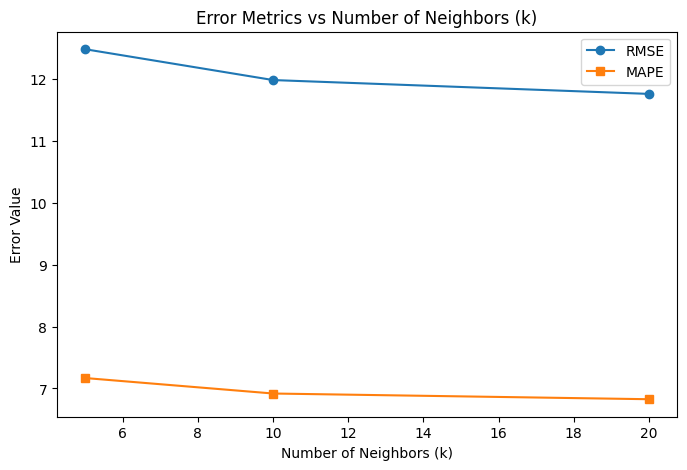

In [ ]:
# Performance vs. Number of Neighbors (k)
plt.figure(figsize=(8, 5))
plt.plot(k_values, rmse_values, marker='o', label='RMSE')
plt.plot(k_values, mape_values, marker='s', label='MAPE')
plt.title('Error Metrics vs Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Error Value')
plt.legend()
plt.show()

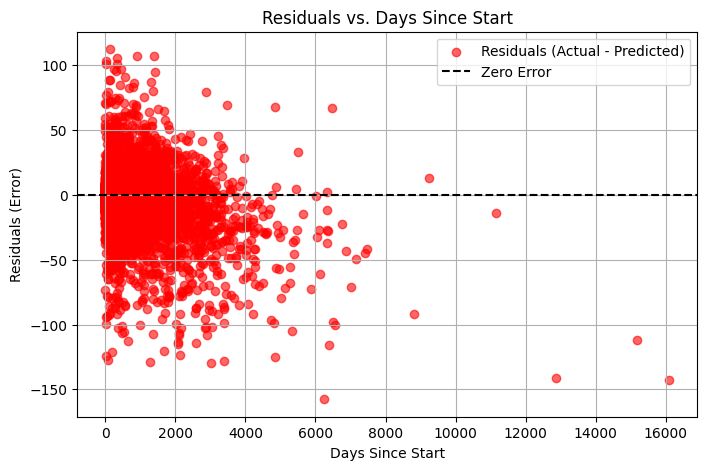

In [ ]:
# Residuals against days
days = [item[1] if len(item) > 1 else None for item in test[:, 5]]

plt.figure(figsize=(8, 5))
plt.scatter(days, residuals[-1], alpha=0.6, color='red', label='Residuals (Actual - Predicted)')
plt.axhline(0, color='black', linestyle='--', label='Zero Error')
plt.title('Residuals vs. Days Since Start')
plt.xlabel('Days Since Start')
plt.ylabel('Residuals (Error)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
for pred_k in predicted_values:
  print('Max:', max(pred_k))
  print('Min:', min(pred_k))
print(np.mean((days)))
print(np.mean(residuals))

Max: 305.5007343433583
Min: 24.237442717108664
Max: 290.8941576013518
Min: 24.418134985021023
Max: 247.92759524554967
Min: 28.090133588384344
311.35428854427835
-0.06732153853220671
